In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import coffea.hist as hist
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams.update({'font.size': 16})
import scipy
import scipy.optimize
from scipy.interpolate import CubicSpline, UnivariateSpline, splrep, BSpline
from landaupy import langauss
import math
import numba
import bitstruct.c as bitstruct

In [2]:
def getDataRaw(fnames):
    N64BWORDS = 1440
    #N64BWORDS = 1536
    times_320 = []
    times = []
    data = []
    format_time320=bitstruct.compile("u64")
    format_time=bitstruct.compile("u64")
    format_header=bitstruct.compile("u16p48")
    format_accheader=bitstruct.compile("u56u8")
    format=bitstruct.compile("u12"*(256*30))
    #format=bitstruct.compile("p4u12u12u12u12u12"*(256*int(30/5)))
    swapformat="8"*(N64BWORDS)
    for fname in fnames:
        print(fname)
        with open(fname, "rb") as f:
            line = f.read((1+4+N64BWORDS)*8)
            lnum = 0
            while len(line) == (1+4+N64BWORDS)*8:
                acc_header = format_accheader.unpack(bitstruct.byteswap("8", line[0*8:1*8]))
                header = format_header.unpack(bitstruct.byteswap("8", line[1*8:2*8]))
                lnum += 1
                if acc_header[0] != 0x123456789abcde or header[0] != 0xac9c:
                    #print("CORRUPT EVENT!!! ", lnum, "%x"%acc_header[0], "%x"%header[0])
                    line = f.read((1+4+N64BWORDS)*8)
                    continue
                times_320.extend(format_time320.unpack(bitstruct.byteswap("8", line[2*8:3*8])))
                times.extend(format_time320.unpack(bitstruct.byteswap("8", line[3*8:4*8])))
                data.extend(format.unpack(bitstruct.byteswap(swapformat, line[5*8:])))
                line = f.read((1+4+N64BWORDS)*8)
    data = np.array(data)
    times = np.array(times)
    times_320 = np.array(times_320)
    return times_320.reshape([-1,]), times.reshape([-1,]), data.reshape([-1, 30, 256])

def getData(fnames):
    data = []
    for fname in fnames:
        with open(fname) as f:
            for line in f:
                data.extend(line.split()[1:31])
    data = np.array(data, dtype='float')
    return data.reshape([-1, 256, 30])    

In [26]:
#_, _, ped_data = getDataRaw(["data/Raw_testData_20230209_115535_b1.txt",])
#times_320, times, data = getDataRaw(["data/Raw_testData_20230209_115328_b1.txt",])

_, _, ped_data = getDataRaw(["/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_142710_b1.txt",])
times_320, times, data = getDataRaw(["/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_115948_b1.txt"])

#_, _, ped_data = getDataRaw(["data/Raw_testData_20230202_144100_b1.txt",])
#times_320, times, data = getDataRaw(["data/Raw_testData_20230202_163840_b1.txt",
#                                     "data/Raw_testData_20230202_172916_b1.txt",
#                                     "data/Raw_testData_20230202_174417_b1.txt",
#                                     "data/Raw_testData_20230202_175022_b1.txt"
#                                    ])

/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_142710_b1.txt
/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_115948_b1.txt


In [27]:
#averages = np.zeros(ped_data.mean(0).shape)
averages = ped_data.mean(0)
stddevs = ped_data.std(0)
#averages = averages.transpose()

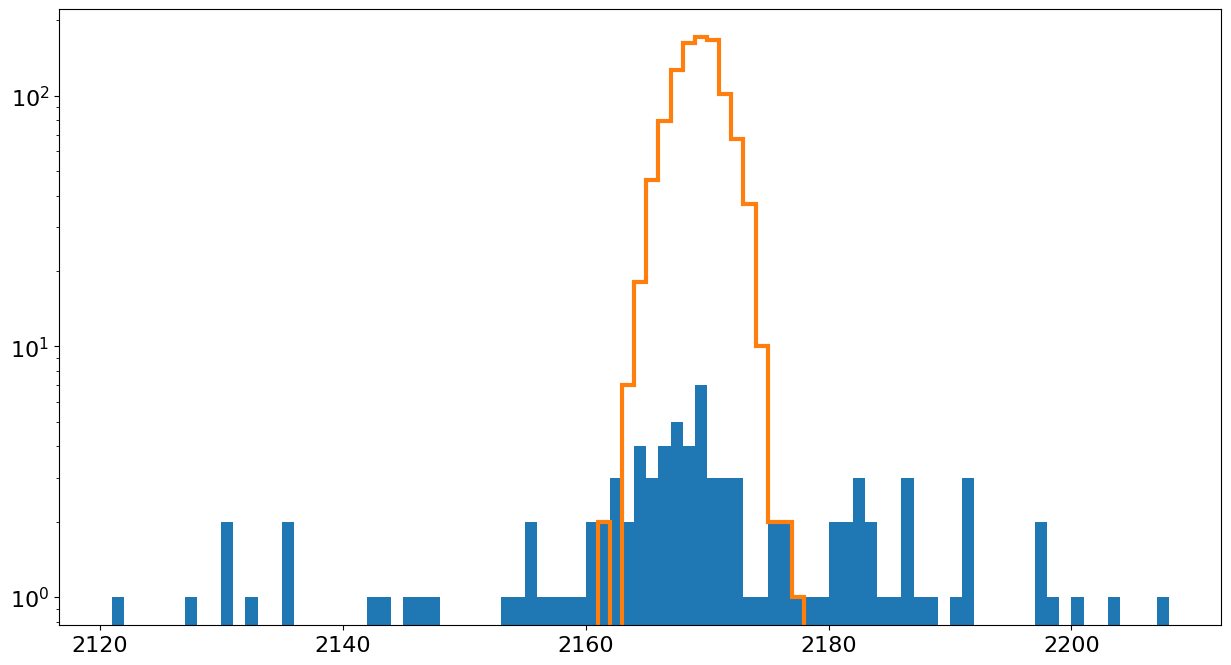

In [28]:
cap = 10
chan = 22
min = ped_data[:,chan,cap].min()
max = ped_data[:,chan,cap].max()+1
plt.hist(ped_data[:,chan,cap], bins=np.linspace(min, max, max-min+1))
min = data[:,chan,cap][data[:,chan,cap]>10].min()
max = data[:,chan,cap].max()+1
plt.hist(data[:,chan,cap], histtype='step', linewidth=3, bins=np.linspace(min, max, max-min+1))
#plt.hist(data[:200,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="1")
#plt.hist(data[200:400,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="2")
#plt.hist(data[400:600,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="3")
#plt.hist(data[600:800,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="4")
#plt.hist(data[800:1000,chan,cap], histtype='step', linewidth=2, bins=np.linspace(min, max, max-min+1), label="5")
#plt.axvline(ped_data[:,21,cap].mean(), color="red")
#plt.legend()
plt.yscale("log")

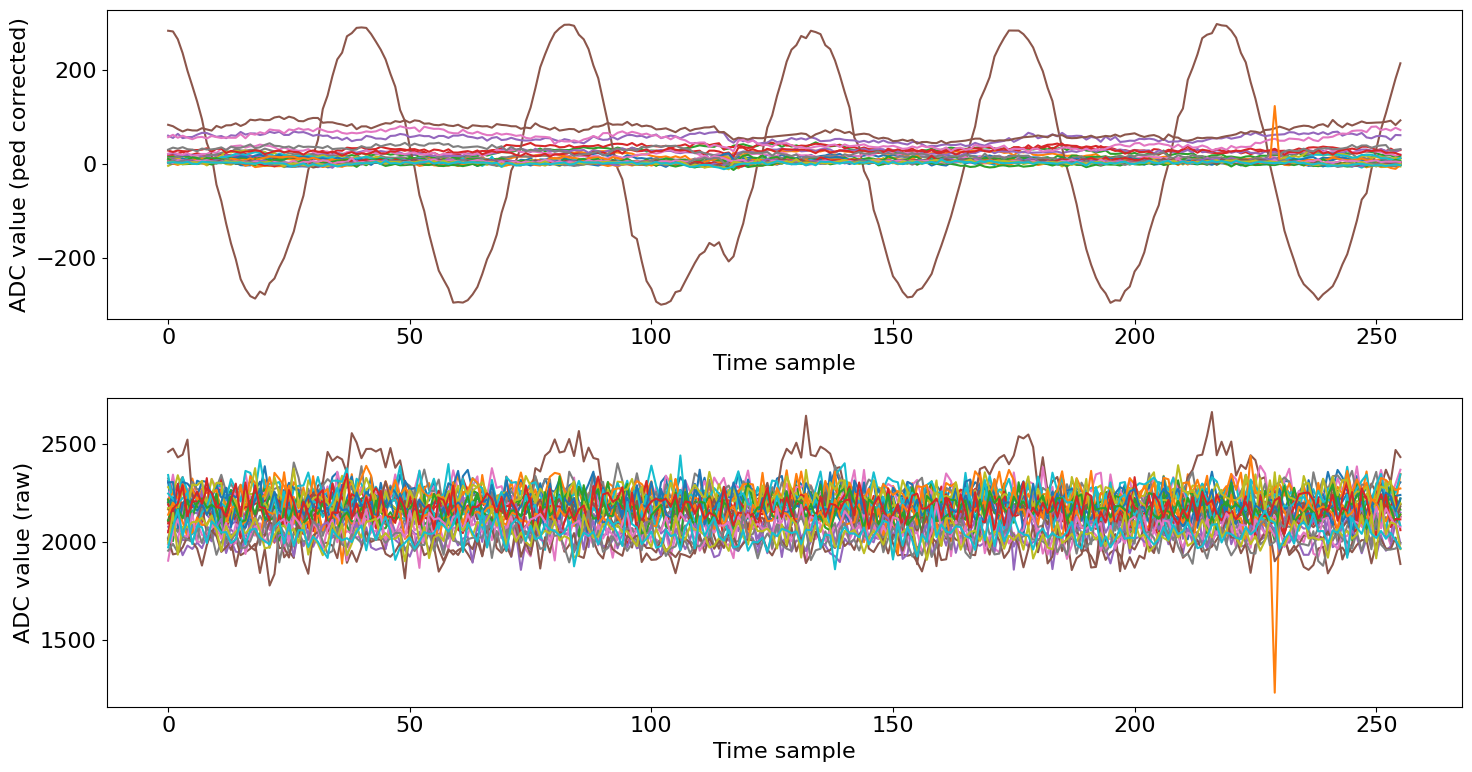

In [29]:
def sine(x, A, B, omega, phi):
    return A * np.sin(omega*x + phi) + B

#channel = 1
#channel_pulse = np.array([5, 11,17,23,29])
#channel_pulse = np.array([0,1,2,3,4,5])+0*6
channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
#channel_pulse = np.array([0,6,12,18,24])
#channel_pulse = np.array([24,25,26,27,28,29])
event = 154

xdata = np.linspace(0, 255,256)
#ydata = data[event,channel,:]-averages[channel,:]
#ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
ydata_pulse_raw = data[event,channel_pulse,:]# - data[event,channel,:].mean()

fig, (ax1, ax2) = plt.subplots(2, 1)
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="Pulse %i"%i)
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

#ax2.plot(xdata, ydata_raw, label="250 MHz sine")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="Pulse %i"%i)
#ax2.legend()
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")

fig.tight_layout()



   extrema [11.57443858]
bs extrema [-266.27562305]
se extrema 11.574438581148403
   extrema [54.11819152]
bs extrema [-269.95619718]
se extrema 54.118191524590195
   extrema [95.69809082]
bs extrema [-269.63954049]
se extrema 95.69809082496114
   extrema [146.77643843]
bs extrema [-276.22422081]
se extrema 146.77643842913892
   extrema [189.50377299]
bs extrema [-284.90155915]
se extrema 189.5037729943967
   extrema [231.21984401]
bs extrema [-269.02034182]
se extrema 231.21984401449745
4.073835060556714
21.484375
[22.58006289 18.50622783]
[ 1.07421875  5.2734375   9.47265625 14.35546875 18.26171875 22.55859375]


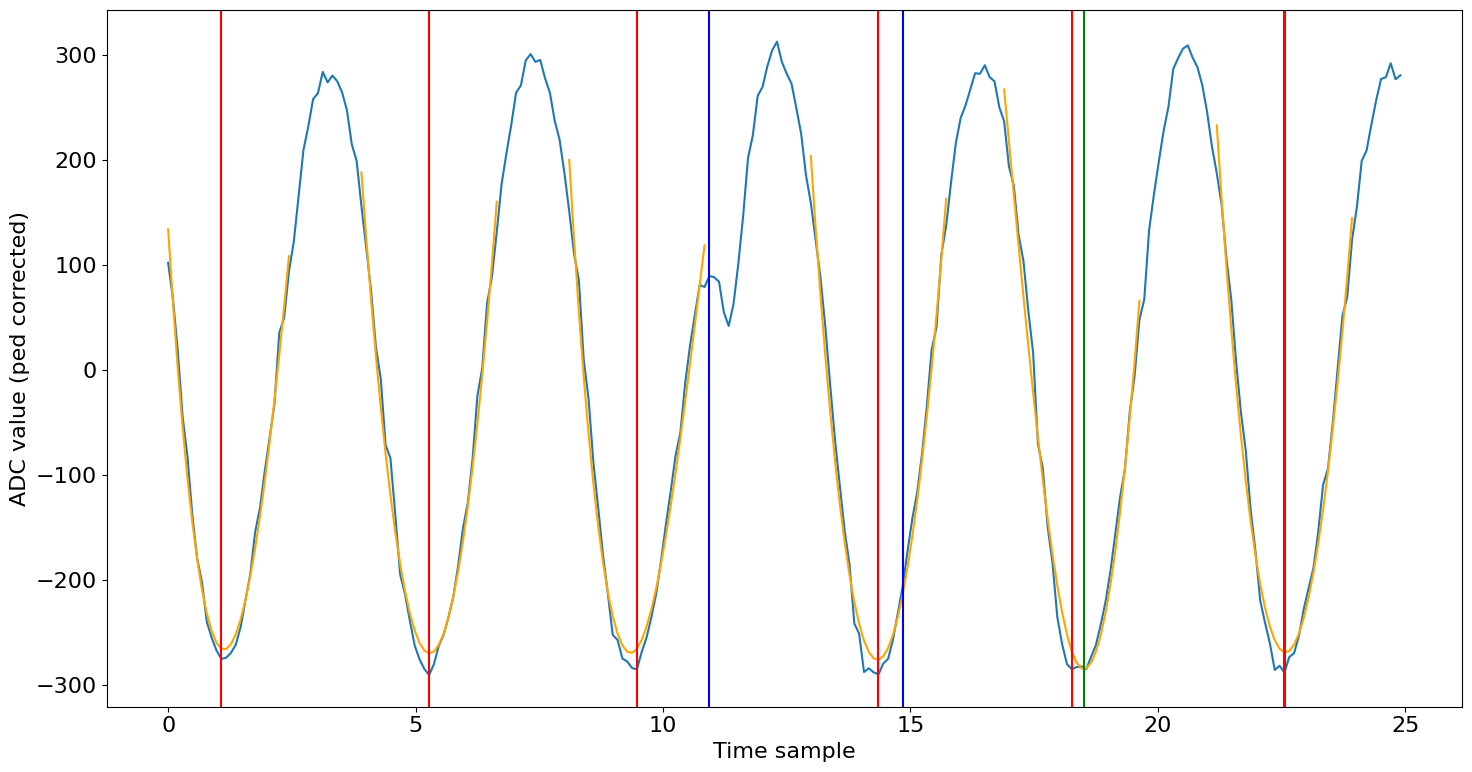

In [30]:
event = 311

xdata = np.linspace(0, 255,256)
ydata = data[event,:,:]-averages[:,:]

channel = ydata.min(axis=1).argmin()

ydata = ydata[channel]

peaks2 = scipy.signal.find_peaks(-1*ydata, height=(-0.5)*ydata.min(), distance = 20)[0]

peaks = []
csl = []
for xp1 in peaks2:
    #xp1 = peaks2.min()
    xp1Cut = (xdata > (xp1-15)) & (xdata < (xp1+15))
    spl = splrep(xdata[xp1Cut], ydata[xp1Cut], k=3, s=10000)
    bs = BSpline(*spl)
    dbs = bs.derivative()
    #print(dcs.solve(0))
    xplot = np.linspace(xp1-15, xp1+15, 100)
    dcs = CubicSpline(xplot, dbs(xplot))
    extrema = dcs.solve(0)
    extrema = extrema[(extrema > (xp1-12)) & (extrema < (xp1+12))]
    print("   extrema", extrema)
    print("bs extrema", bs(extrema))
    extrema = extrema[bs(extrema).argsort()][0]
    print("se extrema", extrema)
    peaks.append(extrema)
    csl.append((xdata[xp1Cut], bs))
peaks = np.array(peaks)
peaks = peaks[(peaks > 0) & (peaks < 256)]
peaks = peaks[np.argsort(bs(peaks))[:2]]

peaks = peaks*25/256
peaks2 = peaks2*25/256

try:
    print(peaks.max()-peaks.min())
    print(peaks2.max()-peaks2.min())
except:
    pass

print(peaks)
print(peaks2)

cw_low = (((times_320[event]+3+1)%8)*32-16)%256*25/256
cw_high = (((times_320[event]+3+1)%8)*32+24)%256*25/256

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(xdata*25/256, ydata, label="Pulse %i"%i)
for x, bs in csl:
    ax1.plot(x*25/256, bs(x), label="Pulse %i"%i, color='orange')
#ax1.plot(xplot, dbs(xplot))
#ax1.plot(xplot, dcs(xplot))
for x in peaks:
    ax1.axvline(x, color="green")

for x in peaks2:
    ax1.axvline(x, color="red")

ax1.axvline(cw_high, color="blue")
ax1.axvline(cw_low, color="blue")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

fig.tight_layout()

(1000,)


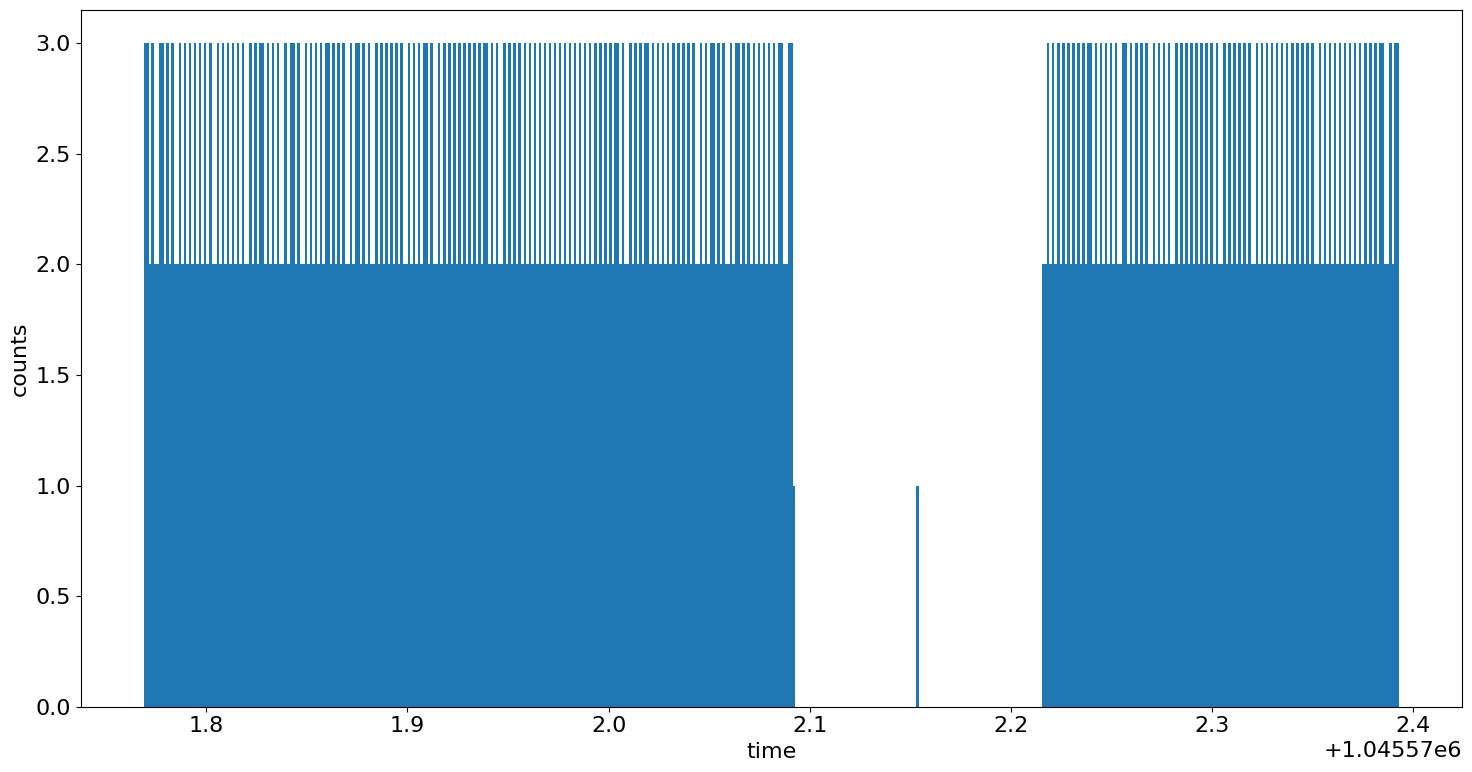

In [31]:
wr_time = ((times>>32) & 0xffffffff) + 1e-9*(4*(times & 0xffffffff))
#wr_time = wr_time[(wr_time > 75) & (wr_time < 85)]
print(wr_time.shape)

fig, (ax1) = plt.subplots(1, 1)
ax1.hist(wr_time, bins=np.linspace(wr_time[0], wr_time[-1], 500))
ax1.set_xlabel("time")
ax1.set_ylabel("counts")
#ax1.set_yscale('log')

fig.tight_layout()


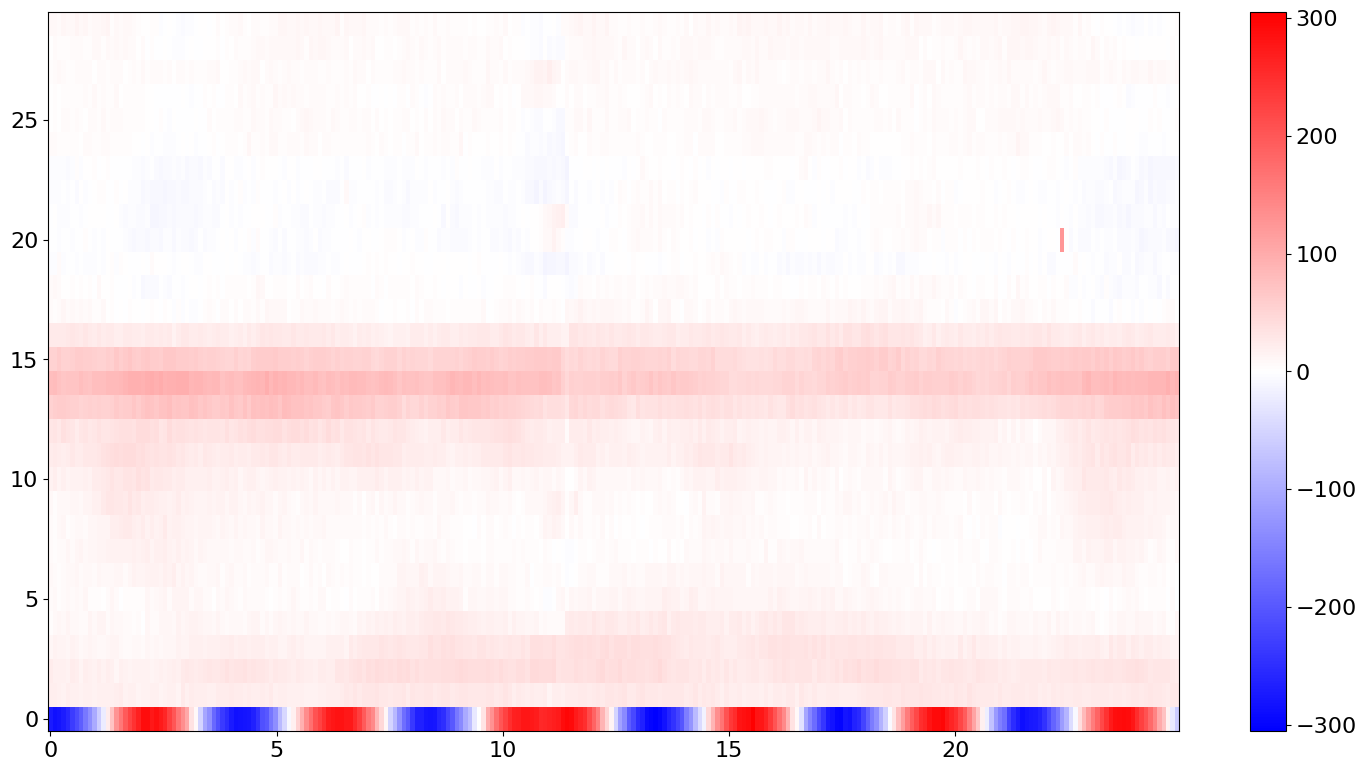

In [32]:
def sine(x, A, B, omega, phi):
    return A * np.sin(omega*x + phi) + B

channels = np.array([5,4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])
#channels = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])

event = 29

xdata = np.linspace(0, 255,256)*25/256
ydata = np.linspace(0, 29, 30)
zdata = data[event,channels,:]-averages[channels,:]

fig, (ax1) = plt.subplots(1, 1)
norm = matplotlib.colors.CenteredNorm()
#norm = matplotlib.colors.SymLogNorm(10)
cm = ax1.pcolormesh(xdata, ydata, zdata, norm=norm, cmap='bwr')
fig.colorbar(cm, ax = ax1)
#ax1.set_xlabel("Time sample")
#ax1.set_ylabel("ADC value (ped corrected)")


fig.tight_layout()


/tmp/ipykernel_221701/1035120471.py:2: RuntimeWarning: overflow encountered in exp
  y = A*np.exp(-1*B*(x-c)**2) - d


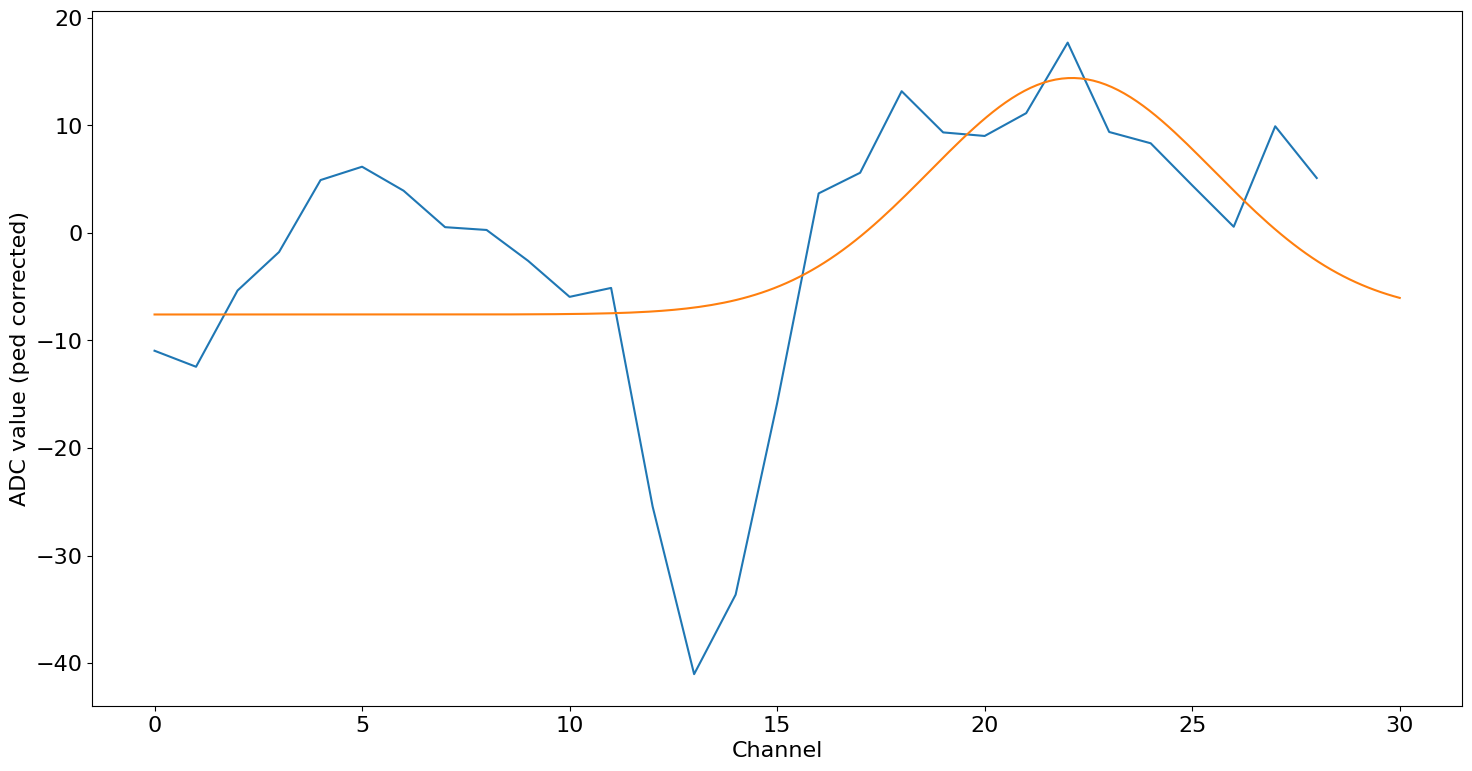

In [33]:
def Gauss(x, A, B, c, d):
    y = A*np.exp(-1*B*(x-c)**2) - d
    return y

np.set_printoptions(threshold=np.inf)

#channels = np.array([0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])

event = 244

xdata = np.linspace(0, 28,29)
ydata = data[event,:,:]-averages[:,:]

ydata = (-1)*ydata.min(axis=1)
ydata = ydata[channels]
#ydata[18] = (ydata[17]+ydata[19])/2
#ydata[26] = (ydata[25]+ydata[27])/2

popt = (ydata.max(), 2, ydata.argmax(), 0)
popt, pcov = scipy.optimize.curve_fit(Gauss, xdata, ydata, p0=popt)

xdraw = np.linspace(0, 30, 200)


fig, (ax1) = plt.subplots(1, 1)
#ax1.hist(centers, bins=np.linspace(0, 30, 30))
ax1.plot(xdata, ydata.flatten(), label="Pulse %i"%i)
ax1.plot(xdraw, Gauss(xdraw, *popt))
ax1.set_xlabel("Channel")
ax1.set_ylabel("ADC value (ped corrected)")


fig.tight_layout()


In [34]:
def Gauss(x, A, B, c, d):
    y = A*np.exp(-1*B*(x-c)**2) - d
    return y

def findCenters(data, averages):
    #channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])
    channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])

    centers = []

    skipped = 0

    print(len(data))
    for event in range(len(data)):
    #event = 40

        ydata = data[event,:,:]-averages[:,:]

        xdata_v = np.linspace(0, 29,29)
        ydata_v = (-1)*ydata.min(axis=1)
        ydata_v = ydata_v[channels]
        ydata_v[18] = (ydata_v[17]+ydata_v[19])/2
        ydata_v[26] = (ydata_v[25]+ydata_v[27])/2

        xdata_h = np.linspace(0, 255,256)
        channel_h = ydata.min(axis=1).argmin()
        ydata_h = ydata[channel_h]

        try:
            popt = (ydata_v.max(), 2, ydata_v.argmax(), 0)
            #popt, pcov = scipy.optimize.curve_fit(Gauss, xdata_v, ydata_v, p0=popt)
            v_pos = popt[2]

            peaks2 = scipy.signal.find_peaks(-1*ydata_h, height=(-0.5)*ydata_h.min(), distance = 20)[0]
            peaks = []
            csl = []
            for xp1 in peaks2:
                xp1Cut = (xdata_h > (xp1-15)) & (xdata_h < (xp1+15))
                spl = splrep(xdata_h[xp1Cut], ydata_h[xp1Cut], k=3, s=10000)
                bs = BSpline(*spl)
                dbs = bs.derivative()
                xplot = np.linspace(xp1-15, xp1+15, 100)
                dcs = CubicSpline(xplot, dbs(xplot))
                extrema = dcs.solve(0)
                extrema = extrema[(extrema > (xp1-12)) & (extrema < (xp1+12))]
                if len(extrema) > 0:
                    extrema = extrema[bs(extrema).argsort()][0]
                else:
                    extrema = xp1 
                peaks.append(extrema)
            peaks = np.array(peaks)
            peaks = peaks*25/256
            h_pos = peaks.max()-peaks.min()

            peak_heights = bs(peaks)
            #if(peak_heights.max() < 0.5*peak_heights.min()):
            centers.append((h_pos, v_pos))
        except:
            skipped += 1

    print("Skipped: ", skipped)
    centers = np.array(centers)
    return centers

centers = findCenters(data, averages)
print(len(centers))
#print(centers[:,0])
#ydata = (-1)*ydata[:,205]

#centers = centers[(centers[:,0] > 2) & (centers[:,0] < 7)]
selection = centers[:,0] > 16
centers[:,0][selection] = 25 - centers[:,0][selection]


1000
Skipped:  0
1000


<class 'numpy.ndarray'>


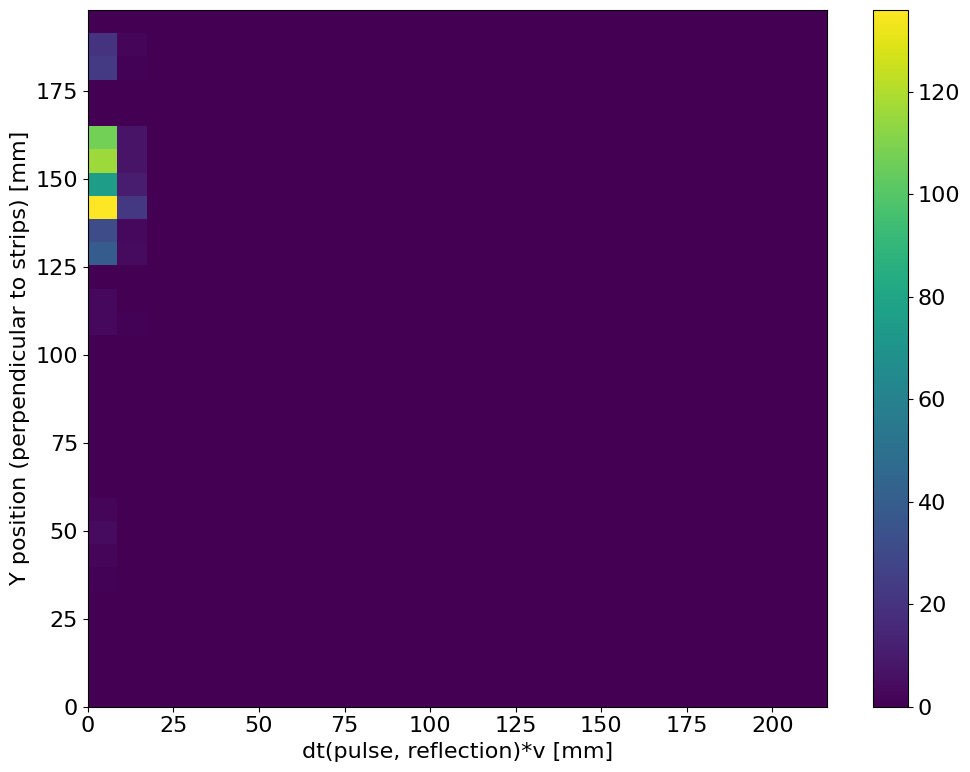

In [35]:
mm_per_ns = 72
offset_in_ns = 3.5
mm_per_strip = 6.6
print(type(centers))

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches([10.5,8])
#ax1.hist(centers[:,1], bins=np.linspace(0, 30, 31))
xbins = (np.linspace(3.5, 6.5, 26)-offset_in_ns)*mm_per_ns
ybins = np.linspace(0, 30, 31)*mm_per_strip
h = ax1.hist2d((centers[:,0]-offset_in_ns)*mm_per_ns,centers[:,1]*mm_per_strip, bins=(xbins, ybins))#, norm=matplotlib.colors.LogNorm())
ax1.set_xlabel("dt(pulse, reflection)*v [mm]")
ax1.set_ylabel("Y position (perpendicular to strips) [mm]")
fig.colorbar(h[3], ax=ax1)
fig.tight_layout()

In [36]:
sine_chan = 0
channel = 1
#channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
#channel_pulse = np.array([0,1,2,3,4,5])+3*6


def ffunc(x, A, offset, xi, sigma):
    return A*scipy.special.voigt_profile(x-offset, sigma, xi)
    #return A*langauss.pdf(x, offset, xi, sigma)
    #return A*(x - offset)**2 + y0


for event in range(0, 200):

    xdata = np.linspace(0, 255,256)
    #ydata = data[event,channel,:]-averages[:,channel]
    #ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
    ydata_pulse = data[event,:,:]-averages[:,:]
    #ydata_pulse_raw = data[event,channel_pulse,:]# - data[event,channel,:].mean()

    channel_pulse = np.array([5,])
    channel_pulse = np.concatenate((channel_pulse, np.array([ydata_pulse.min(axis=1).argmin()])))
    ydata_pulse = ydata_pulse[channel_pulse]
    
    fig, (ax1) = plt.subplots(1, 1)
    
    peaks = scipy.signal.find_peaks(-1*ydata_pulse[channel], height=(-0.5)*ydata_pulse.min(), distance = 20)
    if len(peaks[0]) < 2:
        continue
    
    if abs(peaks[0][0] - peaks[0][1]) > 125:
        amin = peaks[0][1]
    else:
        amin = peaks[0][0]
    min = ydata_pulse[channel,amin]
    
    #popt = (-1000, amin[channel], 10, 10)
    #popt, pcov = scipy.optimize.curve_fit(ffunc, xdata[data_cut], ydata_pulse[channel,:][data_cut], p0=popt)
    
    data_cut = (xdata > amin-20) & (xdata < amin+20)
    cs = CubicSpline(xdata[data_cut], ydata_pulse[channel,:][data_cut])
    xcs = np.linspace(np.max((0,amin-19)), np.min((amin+19,256)), 500)
    t = cs.solve(min * 0.1)
    #print("time: ", t)
    
    cw_low = (((times_320[event]+3+1)%8)*32-16)%256
    cw_high = (((times_320[event]+3+1)%8)*32+24)%256
    popt = (500.0, 0.0, 1.0/20, 0.0)
    popt2 = (500.0, 0.0, 1.0/20, 0.0)
    try:
        popt, pcov = scipy.optimize.curve_fit(sine, xdata[cw_high:cw_high+50], ydata_pulse[sine_chan,cw_high:cw_high+50], p0=popt)
        popt, pcov = scipy.optimize.curve_fit(sine, xdata[cw_high:], ydata_pulse[sine_chan,cw_high:], p0=popt)

        popt2, pcov = scipy.optimize.curve_fit(sine, xdata[cw_low-50:cw_low], ydata_pulse[sine_chan,cw_low-50:cw_low], p0=popt)
        popt2, pcov = scipy.optimize.curve_fit(sine, xdata[:cw_low], ydata_pulse[sine_chan,:cw_low], p0=popt)
    except:
        pass
    #print("period:",2*math.pi/popt[2])
    #print("phi:",popt[3])
    
    for i, d in enumerate(ydata_pulse):
        ax1.plot(xdata, d, label="Pulse %i"%i)
    ax1.axvline(cw_low)
    ax1.axvline(cw_high)
    for peak in peaks[0]:
        ax1.axvline(peak, color="red")
    ax1.plot(xcs, cs(xcs))
    if len(t) > 1 :
        ax1.axvline(t[0], color="orange")
    xsine1 = np.linspace(cw_low, 256, 100)
    xsine2 = np.linspace(0, cw_high, 100)
    ax1.plot(xsine1, sine(xsine1, *popt))
    ax1.plot(xsine2, sine(xsine2, *popt2))
    ax1.set_xlabel("Time sample")
    ax1.set_ylabel("ADC value (ped corrected)")
    
    fig.text(0.1, 0.94, "%i.%09i s"%((times[event]>>32) & 0xffffffff, 4*(times[event] & 0xffffffff)))

    fig.tight_layout()
    fig.savefig("testPlots/Pulse_ch2_%i.png"%event)
    plt.close('all')

/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_142710_b0.txt
/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_115948_b0.txt
/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_142710_b1.txt
/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_115948_b1.txt


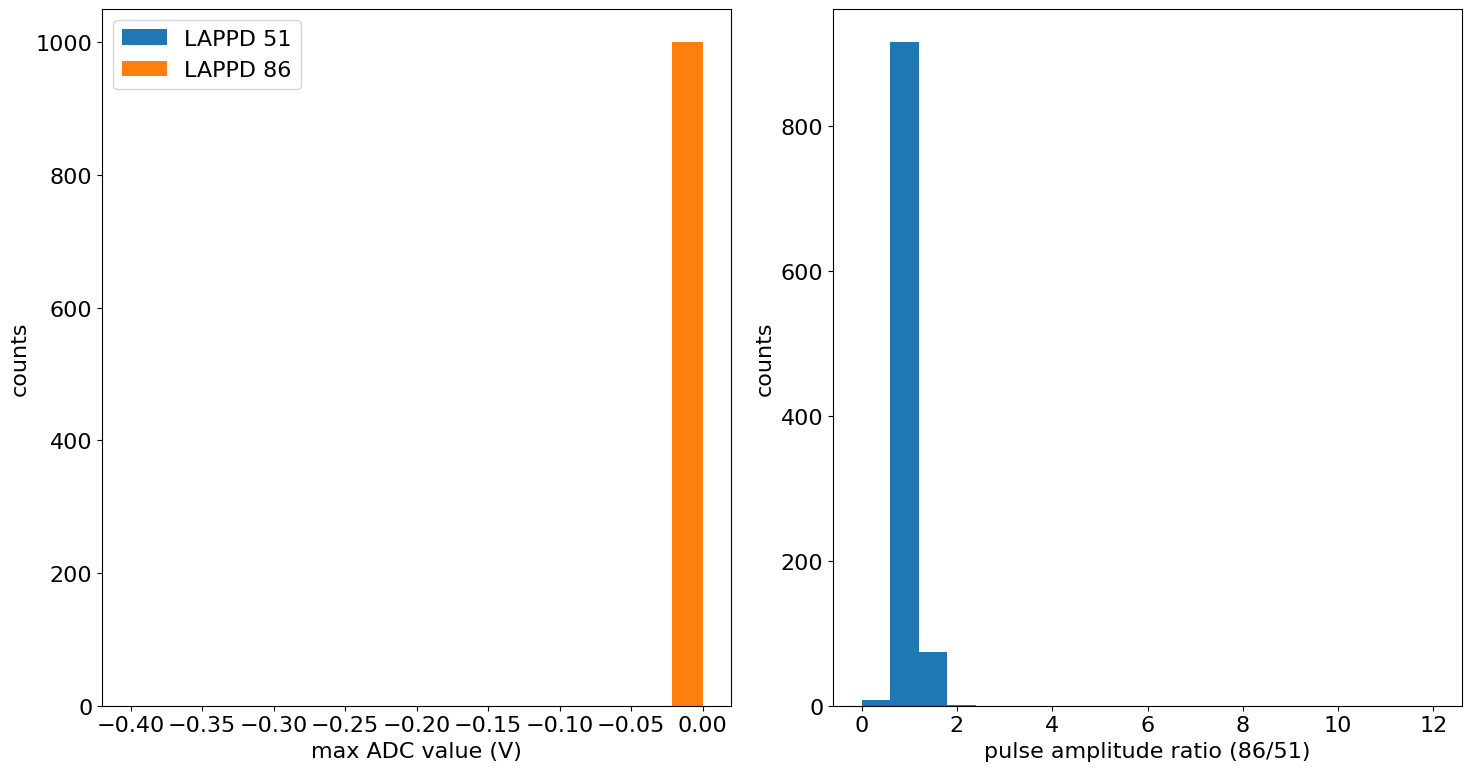

In [37]:
_, _, ped_data_1 = getDataRaw(["/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_142710_b0.txt"])
_, t1, data_1 = getDataRaw(["/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_115948_b0.txt"])

_, _, ped_data_2 = getDataRaw(["/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_142710_b1.txt"])
_, t2, data_2 = getDataRaw(["/home/cameronpoe/Desktop/lappd_tof_container/testData/Raw_testData_20230130_115948_b1.txt"])

channels = np.array([4,3,2,1,0,11,10,9,8,7,6,17,16,15,14,13,12,23,22,21,20,19,18,29,28,27,26,25,24])

averages_1 = ped_data_1.mean(0)
averages_2 = ped_data_2.mean(0)

#xdata = np.linspace(0, 255,256)
ydata_1 = data_1[:,channels,:]-averages_1[channels,:]
ydata_2 = data_2[:,channels,:]-averages_2[channels,:]

ydata_1 = ydata_1.min(axis=1).min(axis=1)
ydata_2 = ydata_2.min(axis=1).min(axis=1)

ydata_1 = ydata_1*1.2/4096
ydata_2 = ydata_2*1.2/4096

bins = np.linspace(-0.4, 0, 20)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(ydata_1, bins=bins, label="LAPPD 51")
ax1.hist(ydata_2, bins=bins, label="LAPPD 86")
ax1.legend()

ax2.hist(ydata_2[:-1]/ydata_1, bins=np.linspace(0, 12, 21))

ax1.set_xlabel("max ADC value (V)")
ax1.set_ylabel("counts")
#ax1.set_title("max pulse amplitude")

ax2.set_xlabel("pulse amplitude ratio (86/51)")
ax2.set_ylabel("counts")
#ax2.set_title("")

fig.tight_layout()
fig.savefig("amplitude_ratio.png")

In [38]:
#STOP EDITING THIS ONE!!!!!
channel = 1
channel_pulse = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])
channel_pulse = np.array([0,1,2,3,4,5])+3*6

def ffunc(x, A, offset, xi, sigma):
    #return A*scipy.special.voigt_profile(x-offset, sigma, gamma)
    return A*langauss.pdf(x, offset, xi, sigma)
    #return A*(x - offset)**2 + y0


for event in range(10):

    xdata = np.linspace(0, 255,256)
    #ydata = data[event,channel,:]-averages[:,channel]
    #ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
    ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
    #ydata_pulse_raw = data[event,channel_pulse,:]# - data[event,channel,:].mean()


    fig, (ax1) = plt.subplots(1, 1)
    
    amin = ydata_pulse.argmin(axis=1)
    min = ydata_pulse.min(axis=1)
    
    #popt = (-1000, amin[1], 10, 10)
    #popt, pcov = scipy.optimize.curve_fit(ffunc, xdata[(xdata > amin[1]-20) & (xdata < amin[1]+20)], ydata_pulse[1,:][(xdata > amin[1]-20) & (xdata < amin[1]+20)], p0=popt)
    
    
    
    for i, d in enumerate(ydata_pulse):
        ax1.plot(xdata, d, label="Pulse %i"%i)
    ax1.axvline((((times_320[event]+4+1)%8)*32+24)%256)
    ax1.axvline((((times_320[event]+4+1)%8)*32-16+256)%256)
    #ax1.axvline((popt[1]+256-56)%256, color="red")
    #ax1.axvline((popt[1]+256-48)%256, color="red")
    #ax1.axvline((amin[1])%256, color="orange")
    #ax1.axvline(popt[1], color="green")
    #plt.plot(xdata[(xdata > amin[1]-20) & (xdata < amin[1]+20)], ffunc(xdata[(xdata > amin[1]-20) & (xdata < amin[1]+20)], *popt))
    ax1.set_xlabel("Time sample")
    ax1.set_ylabel("ADC value (ped corrected)")
    #for i, d in enumerate(ydata_pulse_raw):
    #    ax2.plot(xdata, d, label="Pulse %i"%i)
    #ax2.set_xlabel("Time sample")
    #ax2.set_ylabel("ADC value (raw)")
    
    fig.text(0.1, 0.94, "%i.%09i s"%((times[event]>>32) & 0xffffffff, 4*(times[event] & 0xffffffff)))

    fig.tight_layout()
    fig.savefig("testPlots/Pulse_%i.png"%event)
    plt.close(fig)

(1000, 30, 256) (30, 256)


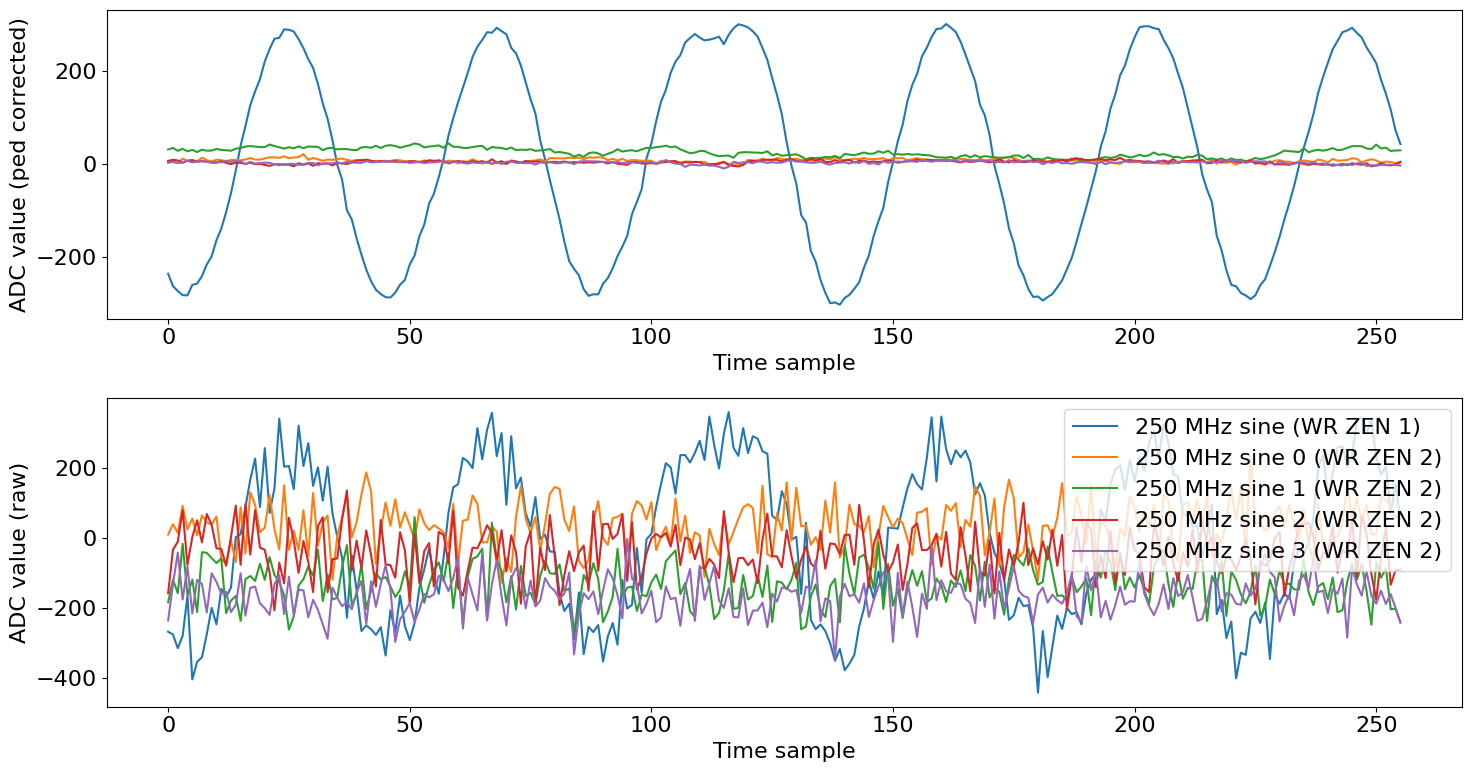

In [39]:
channel = 5
channel_pulse = np.array([11,17,23,29])
event = 9

xdata = np.linspace(0, 255,256)
print(data.shape, averages.shape)
ydata = data[event,channel,:]-averages[channel,:]
ydata_raw = data[event,channel,:] - data[event,channel,:].mean()
ydata_pulse = data[event,channel_pulse,:]-averages[channel_pulse,:]
ydata_pulse_raw = data[event,channel_pulse,:] - data[event,channel,:].mean()

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(xdata, ydata, label="250 MHz sine (WR ZEN 1)")
for i, d in enumerate(ydata_pulse):
    ax1.plot(xdata, d, label="250 MHz sine %i (WR ZEN 2)"%i)
#ax1.legend(loc="lower right")
ax1.set_xlabel("Time sample")
ax1.set_ylabel("ADC value (ped corrected)")

ax2.plot(xdata, ydata_raw, label="250 MHz sine (WR ZEN 1)")
for i, d in enumerate(ydata_pulse_raw):
    ax2.plot(xdata, d, label="250 MHz sine %i (WR ZEN 2)"%i)
ax2.legend(loc="upper right")
ax2.set_xlabel("Time sample")
ax2.set_ylabel("ADC value (raw)")

fig.tight_layout()

In [40]:
nzcdata = data-averages
channel = 5
x1 = 0
x2 = x1+2
y1 = nzcdata[:,channel, x1]
y2 = nzcdata[:,channel, x2]
intercept = x1-(x2-x1)/(y2-y1)*y1
nzc = np.count_nonzero(intercept > x1 & (intercept < x1+1))
print(nzc)
print(4000*nzc/(2*100000))
print(timeOffsets[0][1]*1e12)

550
11.0


NameError: name 'timeOffsets' is not defined

In [ ]:
timeOffsets = []


for ichan in [5, 11, 17, 23, 29]:
    offsets = []
    for iCap in range(256):
        
        cap1 = iCap
        cap2 = (iCap+1)%256
        channel = ichan

        ydata = data[:1000]-averages
        tdata = times_320[:1000]
        #ydata = linDat

        upper = ((((tdata+4+1)%8)*32+16+8)%256)
        lower = ((((tdata+4+1)%8)*32-24+256)%256)
        ugtl = upper > lower

        ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                      | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]


        x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
        y = ydata[:,channel,cap1] - ydata[:,channel,cap2]

        xmin = x.min()
        xmax = x.max()
        y_fit = y[(x > xmax*0.65) | (x < xmin*0.65)]
        x_fit = x[(x > xmax*0.65) | (x < xmin*0.65)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        A = np.column_stack([x_fit**2, x_fit * y_fit, y_fit**2, x_fit, y_fit])
        b = np.ones_like(x_fit)
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        #print(fit)

        try:
            a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("a = %f"%a)
            b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("b = %f"%b)

            dtij = math.atan(b/a)/(math.pi*250000000.0)
            #print("dtij = %f ps"%(dtij*1e12))
            offsets.append(dtij)
        except:
            offsets.append(100.0e-12)

        #plt.clf()
        #plt.scatter(x, y)

        # Plot the least squares ellipse
        x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
        y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
        X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
        Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
        #plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
        #plt.savefig("Ellipse_chan_%i_cap_%i.png"%(ichan, cap1))

    timeOffsets.append(offsets)
    #plt.plot(ydata[0,:,5])

timeOffsets = np.array(timeOffsets)

In [ ]:
timeOffsets2 = []


for ichan in [5, 11, 17, 23, 29]:
    offsets = []
    for iCap in range(256):

        cap1 = iCap
        cap2 = (iCap+1)%256
        channel = ichan

        ydata = data-averages
        #ydata = linDat

        upper = ((((times_320+4+1)%8)*32+16+8)%256)
        lower = ((((times_320+4+1)%8)*32-24+256)%256)
        ugtl = upper > lower

        ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                      | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]


        x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
        y = ydata[:,channel,cap1] - ydata[:,channel,cap2]

        #y = y[(x > 1200) | (x < -1200)]
        #x = x[(x > 1200) | (x < -1200)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        A = np.column_stack([x**2, x * y, y**2, x, y])
        b = np.ones_like(x)
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        #print(fit)

        try:
            a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("a = %f"%a)
            b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
            #print("b = %f"%b)

            dtij = math.atan(b/a)/(math.pi*250000000.0)
            #print("dtij = %f ps"%(dtij*1e12))
            offsets.append(dtij)
        except:
            offsets.append(100.0e-12)

    timeOffsets2.append(offsets)
    #plt.plot(ydata[0,:,5])
    #plt.scatter(x, y)

    # Plot the least squares ellipse
    x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
    y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
    X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
    #plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

timeOffsets2 = np.array(timeOffsets2)

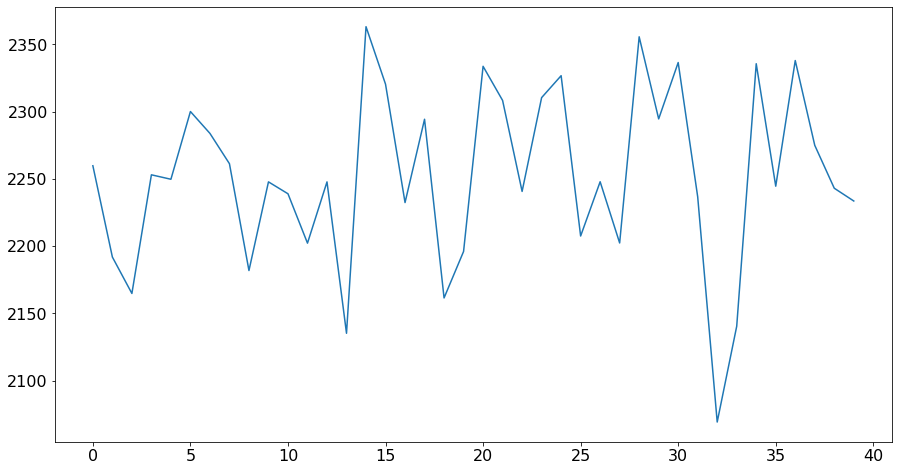

In [ ]:
plt.plot(averages[11,:40])

[0.18948297]
a = 566.871346
b = 54.672174
dtij = 122.419554 ps
angle = -0.001702



Text(0, 0.5, 'Vi - Vj')

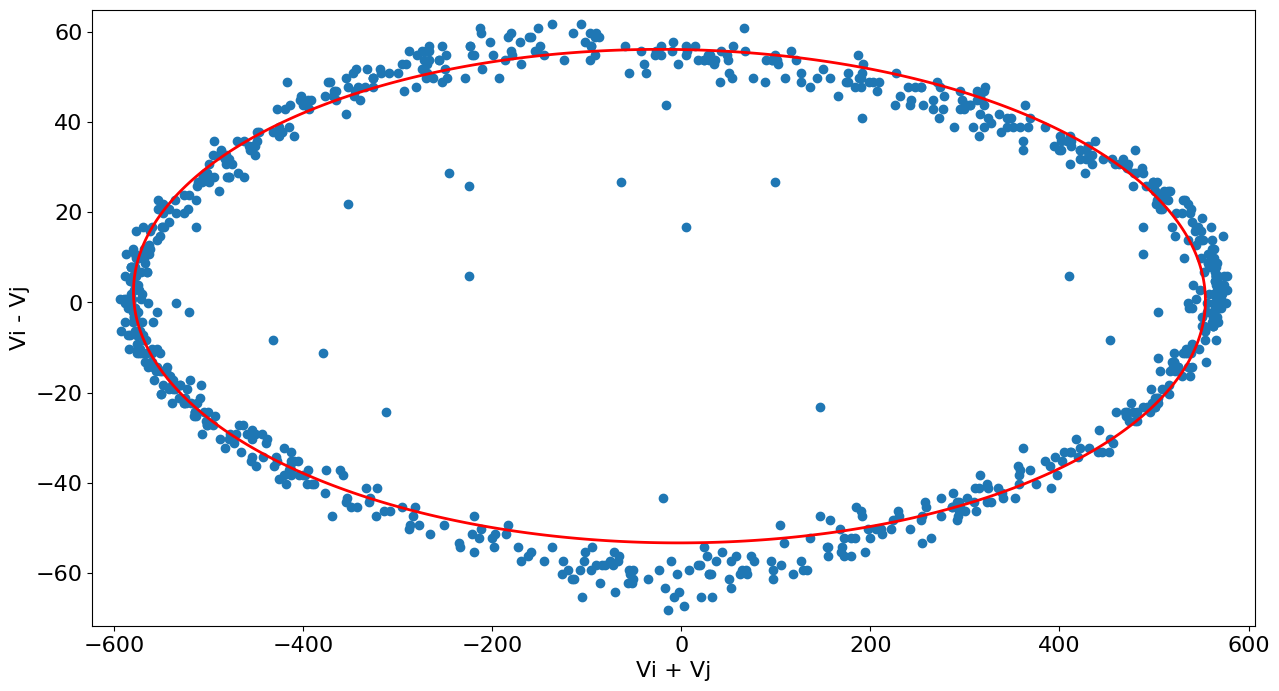

In [ ]:
ydata = data-averages
#ydata = linDat

cap = 2
cap1 = cap
cap2 = (cap+1)%256
channel = 5

upper = ((((times_320+4+1)%8)*32+16+8)%256)
lower = ((((times_320+4+1)%8)*32-24+256)%256)
ugtl = upper > lower

ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                  | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]
    

#ydata = ydata - ydata.mean(axis=0)
    
x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
y = ydata[:,channel,cap1] - ydata[:,channel,cap2]
#x = ydata[:,cap2,11] + ydata[:,cap1,17]
#y = ydata[:,cap1,17] - ydata[:,cap2,11]


y_fit = y
x_fit = x
xmin = x.min()
xmax = x.max()
y_fit = y[(x > xmax*0.50) | (x < xmin*0.50)]
x_fit = x[(x > xmax*0.50) | (x < xmin*0.50)]

#y_fit = y[(x > 1.6) | (x < 0.9)]
#x_fit = x[(x > 1.6) | (x < 0.9)]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x_fit**2, x_fit * y_fit, y_fit**2, x_fit, y_fit])
b = np.ones_like(x_fit)
fit, residuals, _, _ = np.linalg.lstsq(A, b, rcond=None)
print(residuals/18)

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

tmp_a = np.max((a,b))
tmp_b = np.min((a,b))
a = tmp_a
b = tmp_b

dtij = math.atan(b/a)/(math.pi*250000000.0)
print("dtij = %f ps"%(dtij*1e12))
#print(timeOffsets[cap1:cap2].sum()*1e12)

theta = math.atan((fit[2]-fit[0]-math.sqrt((fit[2]-fit[0])**2+fit[1]**2))/fit[1])
print("angle = %f\n"%(theta))

plt.scatter(x, y)
#plt.errorbar(x, y, xerr=4.2, yerr=4.2, fmt="o")

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x.min() if x.min() < 0 else 0.95*x.min(),1.05*x.max(),300)
y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

plt.xlabel("Vi + Vj")
plt.ylabel("Vi - Vj")

#plt.plot(np.abs(np.fft.fft(sineData[0,5,:]))[1:30])

a = 19.938347
b = 1.569182
dtij = 100.000000 ps
angle = -0.000000



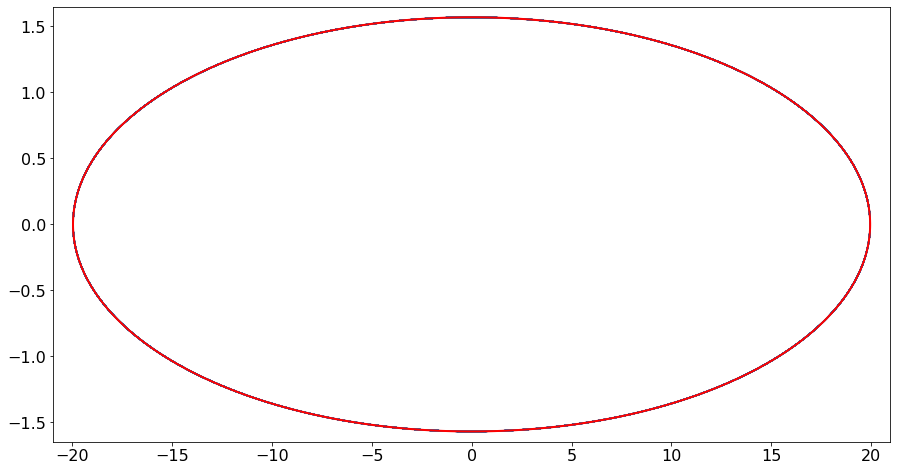

In [ ]:
def func(t, A, fin, phi, P):
    a = A*np.sin(2*math.pi*fin*t + phi) + P
    b = 0#A*np.sin(2*math.pi*fin*t + phi)**2 + P
    return a + b

A1 = 10
A2 = 10
fin1 = 250e6
fin2 = 250e6
phi1 = 0
phi2 = 0
P1 = 0
P2 = 0

t=np.linspace(0, 100e-9, 100000)
dt = 100e-12
x = func(t,      A1, fin1, phi1, P1) + func(t + dt, A2, fin2, phi2, P2)
y = func(t + dt, A2, fin2, phi2, P2) - func(t,      A1, fin1, phi1, P1)

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x**2, x * y, y**2, x, y])
b = np.ones_like(x)
fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

dtij = math.atan(min((a,b))/max((a,b)))/(math.pi*fin1)
print("dtij = %f ps"%(dtij*1e12))

theta = math.atan((fit[2]-fit[0]-math.sqrt((fit[2]-fit[0])**2+fit[1]**2))/fit[1])
print("angle = %f\n"%theta)

plt.plot(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

(5, 256)


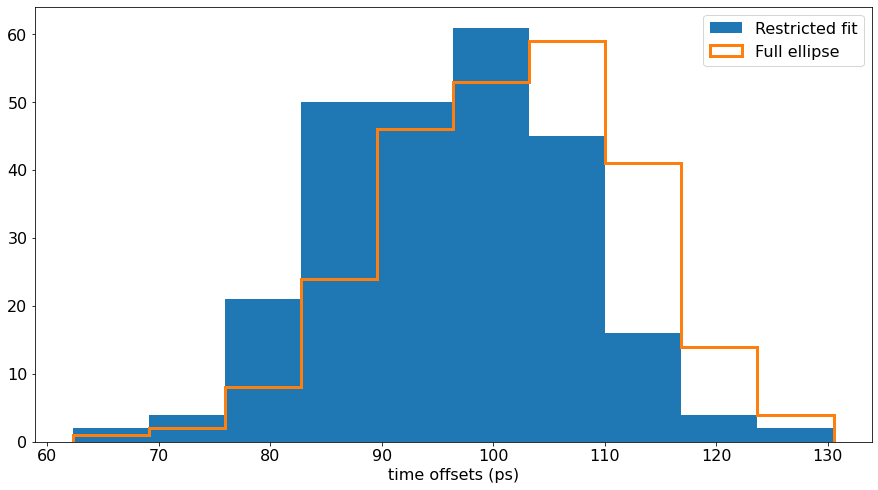

In [ ]:
_, bins, _ = plt.hist(timeOffsets[1][:-1]*1e12, label="Restricted fit")
plt.hist(timeOffsets2[1][:-1]*1e12, bins=bins, histtype='step', linewidth=3, label="Full ellipse")
plt.legend()
plt.xlabel("time offsets (ps)")
print(timeOffsets.shape)

Text(0.5, 0, 'time difference (ps)')

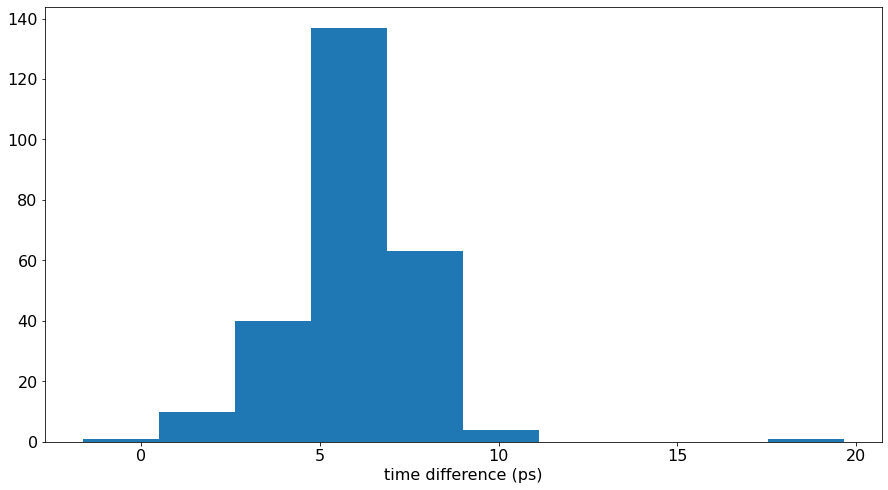

In [ ]:
plt.hist((timeOffsets2[1]-timeOffsets[1])*1e12)
plt.xlabel("time difference (ps)")

25293.42452471538
25672.475766807092
25752.809738072665
25541.15618023134
25656.351218126845


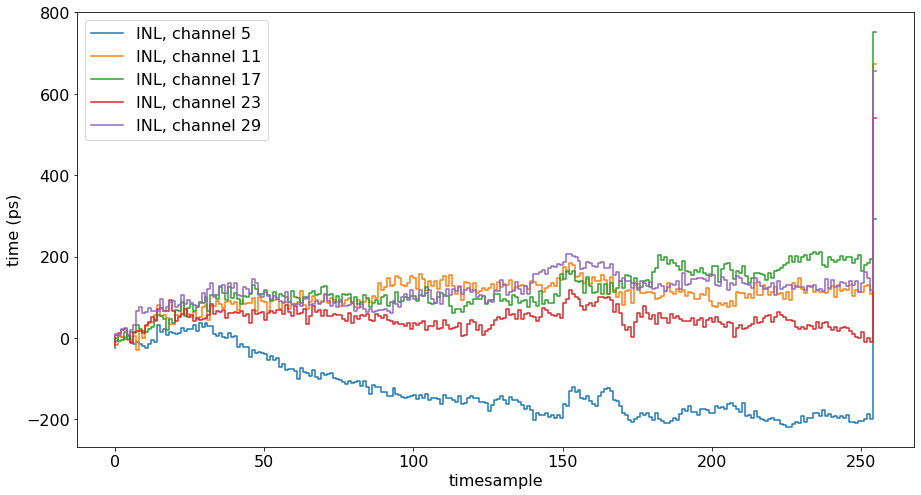

In [ ]:
for iChan in range(0,5):
    ts_loc = timeOffsets[iChan]
    mean_ts = 25000e-12/256#ts_loc.mean()
    DNL = ts_loc[:] - mean_ts
    #plt.step(np.linspace(0, 255, 256), DNL*1e12, label="Differential non-linearity")
    INL = np.array([sum(DNL[:i+1]) for i in range(len(ts_loc))])
    plt.step(np.linspace(0, 255, 256), INL*1e12, label="INL, channel %i"%(iChan*6+5))
    plt.ylabel("time (ps)")
    plt.xlabel("timesample")
    plt.legend()
    print(sum(ts_loc)*1e12)

[ 0.55504864 -0.01459959  5.29814465 -0.07663249  0.01247214]
a = 1.344045
b = 0.435023
dtij = 398.557083 ps


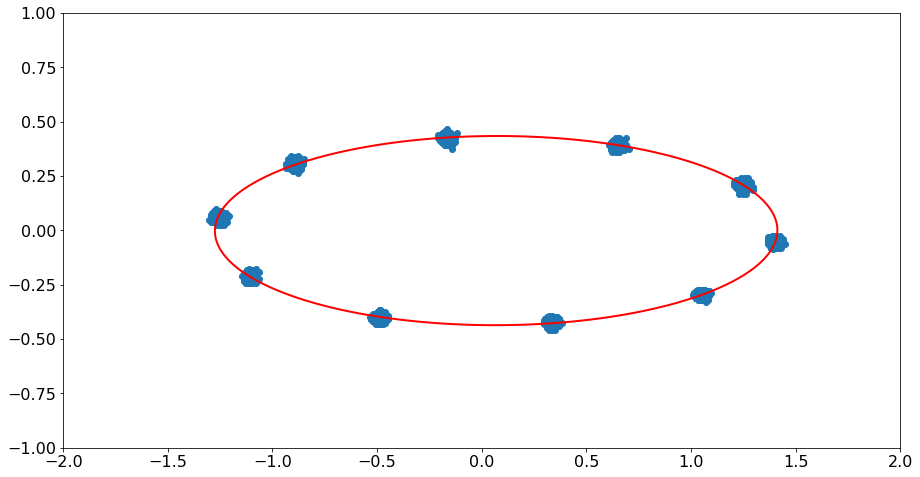

In [ ]:
x_tsdata = []
y_tsdata = []
with open("tek0002CH2.csv") as f:
    for line in f:
        vals = line.split(",")
        if(len(vals) == 2):
            x_tsdata.append(float(vals[0]))
            y_tsdata.append(float(vals[1]))

x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)
            
x = y_tsdata[:-1] + y_tsdata[1:]
y = y_tsdata[:-1] - y_tsdata[1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.column_stack([x**2, x * y, y**2, x, y])
b = np.ones_like(x)
fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
print(fit)

a = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]+math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("a = %f"%a)
b = -math.sqrt(2*(fit[0]*fit[4]**2+fit[2]*fit[3]**2-fit[1]*fit[3]*fit[4]-(fit[1]**2-4*fit[0]*fit[2]))*(fit[0]+fit[2]-math.sqrt((fit[0]-fit[2])**2+fit[1]**2)))/(fit[1]**2 - 4*fit[0]*fit[2])
print("b = %f"%b)

dtij = math.atan(b/a)/(math.pi*250000000.0)
print("dtij = %f ps"%(dtij*1e12))
plt.scatter(x, y)

# Plot the least squares ellipse
x_coord = np.linspace(-2,2,300)
y_coord = np.linspace(-1,1,300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

In [ ]:
x_tsdata = np.array(x_tsdata)
y_tsdata = np.array(y_tsdata)

popt=(0.75, 0.0, 1.50/1e-9, 0.0)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[50:60], y_tsdata[50:60], p0=popt)
popt, pcov = scipy.optimize.curve_fit(sine, x_tsdata[0:100], y_tsdata[0:100], p0=popt)
print(*popt)

diff = y_tsdata - sine(x_tsdata, *popt)

plt.plot(x_tsdata[:200], y_tsdata[:200])

x_sim = np.linspace(x_tsdata[:200].min(), x_tsdata[:200].max(), 2000)
plt.plot(x_sim, sine(x_sim, *popt), label="sine fit")

plt.plot(x_tsdata[:200], diff[:200])

AttributeError: module 'scipy' has no attribute 'optimize'

(100, 30, 256) 1455.91


Text(0.5, 0, 'Pedestal ADC')

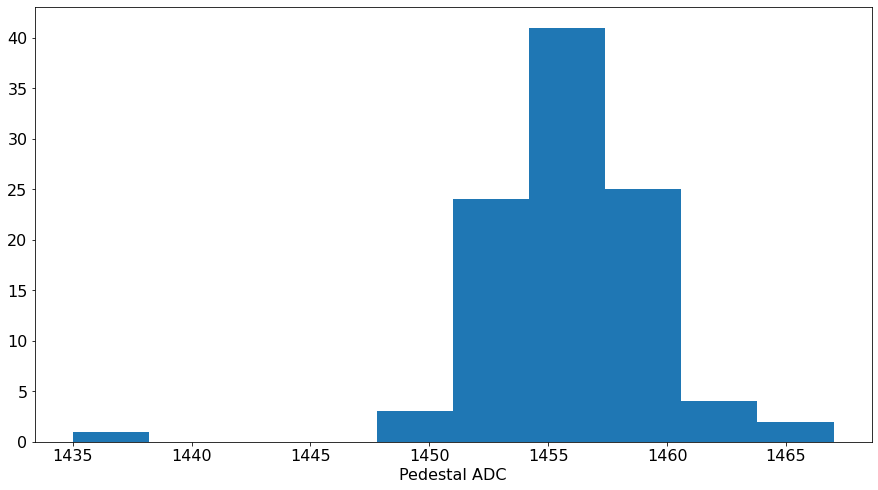

In [ ]:
pedestal = 0x580
channel = 24
cap = 25

_, pdl = getDataRaw("data/Raw_testData_scan_pedestals_%i_20220915_164139_b0.txt"%pedestal)

print(pdl.shape, pdl[:,channel,cap].mean())
plt.hist(pdl[:,channel,cap])#-averages[channel,:])
plt.xlabel("Pedestal ADC")
#plt.plot(pdl[0,11,:]-averages[:,11])

In [ ]:
means = []
x_vals = [i for i in range(0x10, 0xfff, 0x10)]
for i in x_vals:
    if i % 0x100 == 0: print(i)
    _, _, pedData = getDataRaw("data/Raw_testData_scan_pedestals_%i_20221208_170018_b1.txt"%i)
    means.append(pedData.mean(0))
means = np.array(means)

256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840


Text(0, 0.5, 'measured ADC')

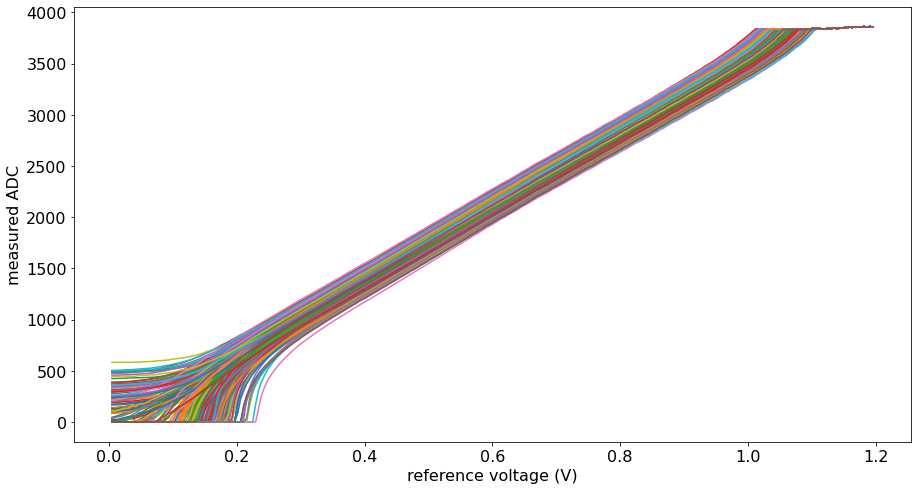

In [ ]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])

channel = 15

for i in range(256):
    meanList = np.array([mean[channel,i] for mean in means])
    plt.plot(refVoltage, meanList)
    
plt.xlabel("reference voltage (V)")
plt.ylabel("measured ADC")

In [ ]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except(ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [ ]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in range(0x10, 0xfff, 0x10)])

def lineraize_wrap(f, val):
    try:
        return f(val)
    except(ValueError):
        if val < 2000:
            return 0
        else:
            return 1.2

vlineraize_wrap = np.vectorize(lineraize_wrap)
        
voltageLin = []
for j in range(0, 30):
    voltageLin.append([])
    for i in range(0, 256):
        meanList = means[:,j,i]
        meanList = savitzky_golay(meanList, 21, 4)
        voltageLin[j].append(scipy.interpolate.interp1d(meanList, refVoltage))
        

In [ ]:
xv = np.array([adc for adc in range(4096)])
#yv = vlineraize_wrap(voltageLin[6][0], xv)

linDat = []
for j in range(0, 30):
    for i in range(0, 256):
        linDat.append(vlineraize_wrap(voltageLin[j][i], data[:,j,i]))
linDat = np.vstack(linDat).transpose().reshape([-1,30,256])

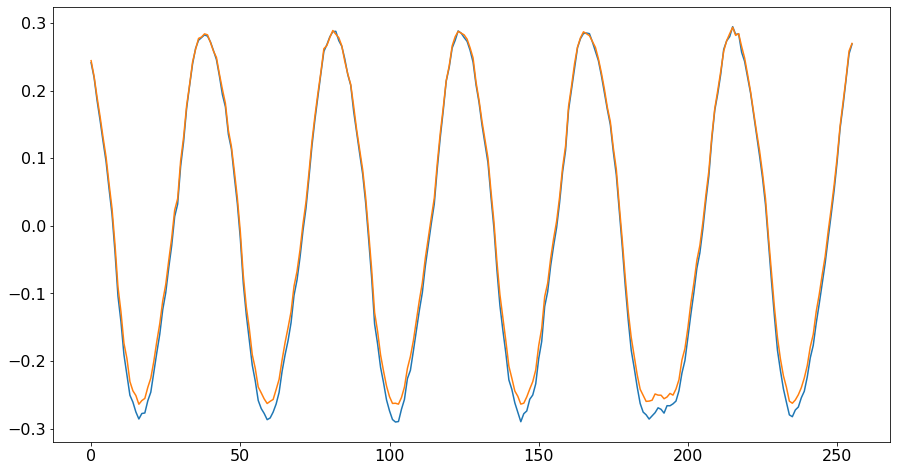

In [ ]:
plt.plot((data[0,5,:]-averages[5,:])*1.2/4096)
plt.plot(linDat[0,5,:]-linDat[0,5,:].mean())

In [ ]:
refVoltage = np.array([(float(i)/(2**12))*1.2 for i in x_vals])
for ichan in [5, 11, 17, 23, 29]:
    for iCap in range(256):
#for ichan in [5]:
#    for iCap in range(3):
        cap1 = iCap
        cap2 = (iCap+1)%256
        channel = ichan

        ydata = data[:1000]-averages
        tdata = times_320[:1000]
        #ydata = linDat

        upper = ((((tdata+4+1)%8)*32+16+8)%256)
        lower = ((((tdata+4+1)%8)*32-24+256)%256)
        ugtl = upper > lower

        ydata = ydata[ugtl & (np.logical_not((cap1 >= lower) & (cap2 <= upper))) 
                      | ((cap1 == 255) & ((lower < 204) & (upper < 204)))]


        x = ydata[:,channel,cap2] + ydata[:,channel,cap1]
        y = ydata[:,channel,cap1] - ydata[:,channel,cap2]

        xmin = x.min()
        xmax = x.max()
        y_fit = y[(x > xmax*0.5) | (x < xmin*0.5)]
        x_fit = x[(x > xmax*0.5) | (x < xmin*0.5)]
        #y = y[(x > 4) | (x < 2.3)]
        #x = x[(x > 4) | (x < 2.3)]

        # Formulate and solve the least squares problem ||Ax - b ||^2
        A = np.column_stack([x_fit**2, x_fit * y_fit, y_fit**2, x_fit, y_fit])
        b = np.ones_like(x_fit)
        fit = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
        #print(fit)

        plt.clf()
        
        fig, ax = plt.subplots(2,2)
        
        ax[0,1].scatter(x, y)

        # Plot the least squares ellipse
        x_coord = np.linspace(1.05*x.min(),1.05*x.max(),300)
        y_coord = np.linspace(1.05*y.min(),1.05*y.max(),300)
        X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
        Z_coord = fit[0] * X_coord ** 2 + fit[1] * X_coord * Y_coord + fit[2] * Y_coord**2 + fit[3] * X_coord + fit[4] * Y_coord
        ax[0,1].contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
        ax[0,1].set_xlabel("Vi + Vj")
        ax[0,1].set_ylabel("Vi - Vj")
        
        
        _, bins, _ = ax[0,0].hist(ped_data[:,channel,cap1])
        ax[0,0].hist(ped_data[:,channel,cap2], histtype='step', linewidth=3)
        ax[0,0].set_xlabel("pedestal adc value")

        _, bins, _ = ax[1,0].hist(data[:,channel,cap1])
        ax[1,0].hist(data[:,channel,cap2], histtype='step', linewidth=3)
        ax[1,0].set_xlabel("sinewave adc value")
        
        for i in [cap1,cap2]:#range(256):
            meanList = np.array([mean[channel,i] for mean in means])
            ax[1,1].plot(refVoltage, meanList)

        ax[1,1].set_xlabel("reference voltage (V)")
        ax[1,1].set_ylabel("measured ADC")

        fig.tight_layout()
        fig.savefig("Ellipse_chan_%i_cap_%i.png"%(ichan, cap1))
        plt.close(fig)
        

<Figure size 1080x576 with 0 Axes>

972.3077791810932 -13.06023434046942 0.14729237814801824 -7.70303954554642
mse: 0.656317


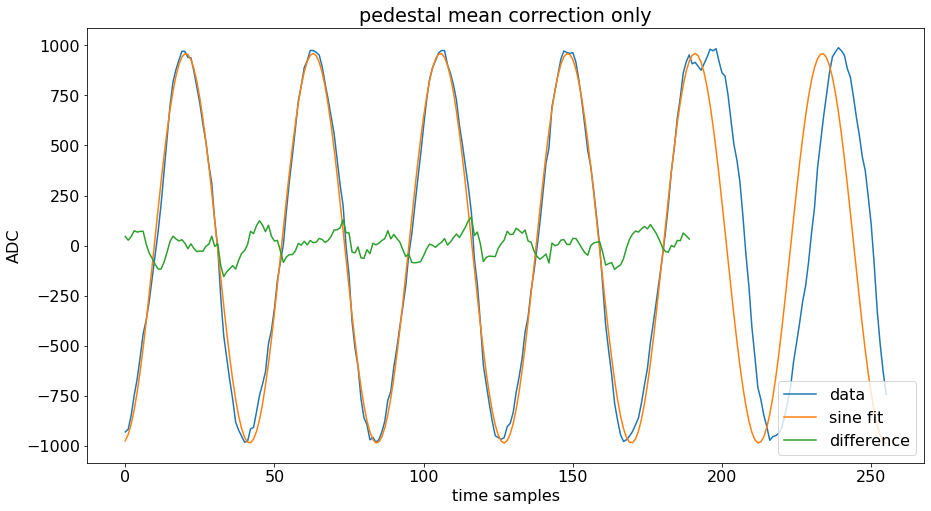

In [ ]:
event = 15
channel = 5

xdata = np.linspace(0, 255,256)
ydata = data[event,channel,:]-averages[channel,:]
#ydata = linDat[event, :, 5]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(1000.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:170], ydata[0:170], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
pmco_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("pedestal mean correction only")
plt.xlabel("time samples")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*1000, label="difference")

plt.legend(loc="lower right")

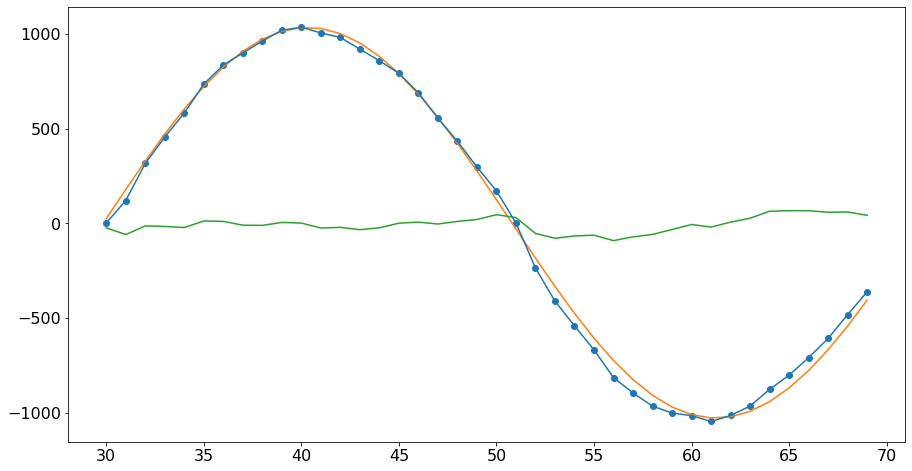

In [ ]:
plt.scatter(xdata[30:70], ydata[30:70], label="data")
plt.errorbar(xdata[30:70], ydata[30:70], yerr=3, label="data")

plt.plot(xdata[30:70], sine(xdata[30:70], *popt), label="sine fit")

plt.plot(xdata[30:70], diff[30:70]*popt[0], label="difference")

In [ ]:
xdata = np.linspace(0, 255,256)
#ydata = sineData[event,:,5]-averages[:,5]
ydata = linDat[event, :, channel]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(2.0, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
vlo_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Voltage linearization only")
plt.xlabel("time samples")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190]*popt[0], label="difference")

plt.legend(loc="lower right")

ValueError: `ydata` must not be empty!

In [ ]:
xdata = np.cumsum(timeOffsets)*1e9
ydata = data[event,channel,:]-averages[channel,:]
#ydata = linDat[event, :, 5]

#popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(400.0, 0.0, 1.0/5000, 0.0))
#popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
#print(*popt)

diff = (ydata - sine(xdata, *popt))/popt[0]
toco_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset calibration only")
plt.xlabel("time (ns)")
plt.ylabel("ADC")

plt.plot(xdata, ydata, label="data")

#plt.plot(xdata, sine(xdata, *popt), label="sine fit")

#plt.plot(xdata[:190], np.abs(diff[:190]*1000), label="difference")

plt.legend(loc="lower right")

ValueError: operands could not be broadcast together with shapes (256,) (1280,) 

1
-0.1023912653719021 -0.007423412039230607 1.5038325623786257 -11.022060226113771
Frequency: 239.342386 MHz

mse: 0.005432


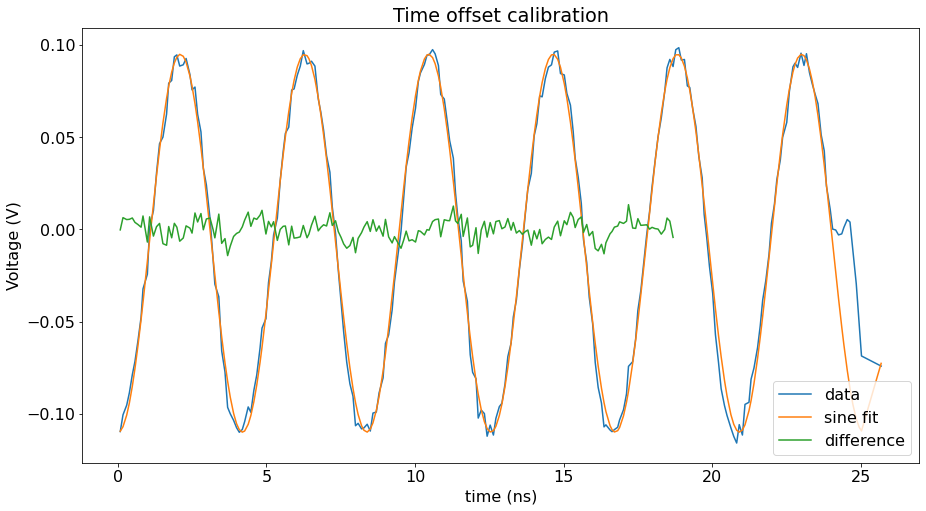

In [ ]:
event = 22
channel = 11
iTO = int((channel-5)/6)
print(iTO)

#xdata = np.linspace(0, 25-0.4, 256)
xdata = np.cumsum(timeOffsets[iTO])*1e9#*timeOffsets[iTO].sum()*1e9/25
ydata = (data[event,channel,:]-averages[channel,:])*1.2/4096
#ydata = linDat[event, channel, :]

popt, pcov = scipy.optimize.curve_fit(sine, xdata[50:100], ydata[50:100], p0=(0.2, 0.0, 1.0/20, 0.0))
popt, pcov = scipy.optimize.curve_fit(sine, xdata[0:190], ydata[0:190], p0=popt)
print(*popt)

print("Frequency: %f MHz\n"%(1000*abs(popt[2])/(2*math.pi)))

diff = (ydata - sine(xdata, *popt))
all_diff = diff
print("mse: %f"%((diff**2)[:190].sum()))

plt.title("Time offset calibration")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (V)")

plt.plot(xdata, ydata, label="data")

plt.plot(xdata, sine(xdata, *popt), label="sine fit")

plt.plot(xdata[:190], diff[:190], label="difference")

plt.legend(loc="lower right")

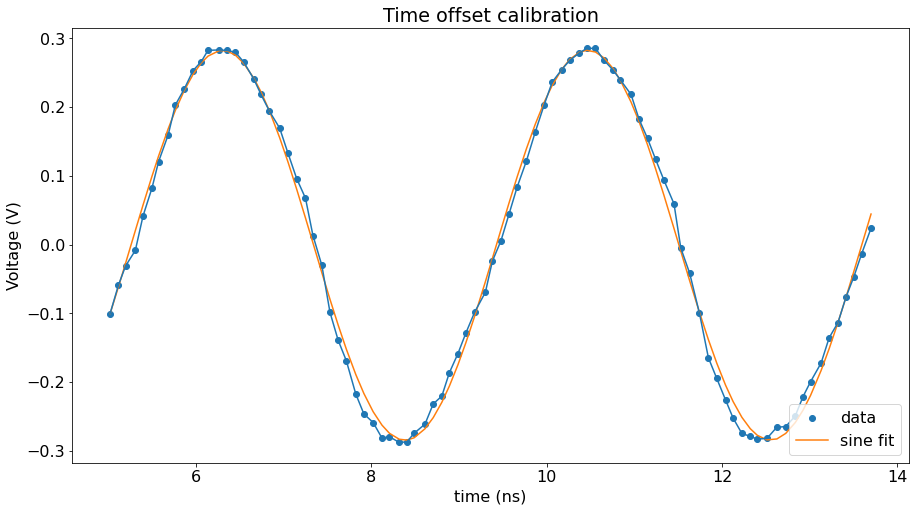

In [ ]:
t = 20
s = slice(30+t,120+t)

plt.scatter(xdata[s], ydata[s], label="data")
plt.errorbar(xdata[s], ydata[s], yerr=3*1.2/4096)

plt.plot(xdata[s], sine(xdata[s], *popt), label="sine fit")

#plt.plot(xdata[s], diff[s], label="difference")

plt.title("Time offset calibration")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (V)")
plt.legend(loc="lower right")

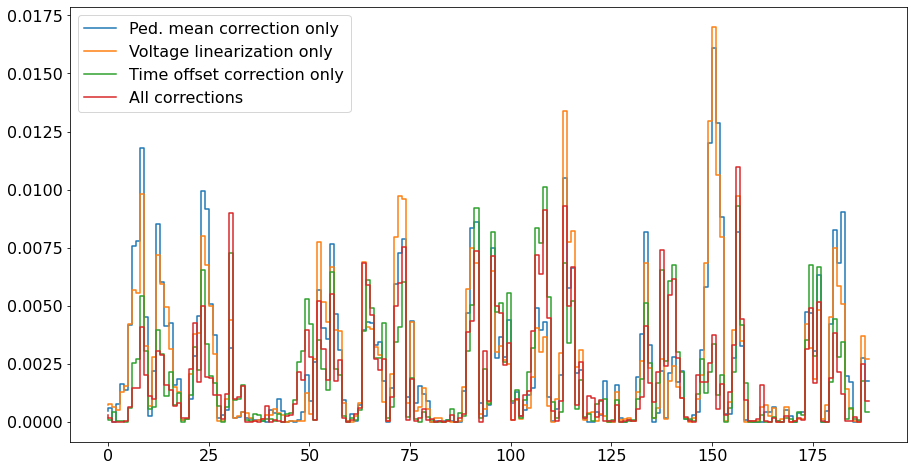

In [ ]:
xdat = np.linspace(0, 189, 190)
plt.step(xdat,pmco_diff[:190]**2, label="Ped. mean correction only")
plt.step(xdat,vlo_diff[:190]**2, label="Voltage linearization only")
plt.step(xdat,toco_diff[:190]**2, label="Time offset correction only")
plt.step(xdat,all_diff[:190]**2, label="All corrections")
plt.legend()